<a href="https://colab.research.google.com/github/Sachin737/deepL/blob/main/assignment_5/assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
!ls "drive/MyDrive/Colab Notebooks/Data/"

test  train  val


In [42]:
DIR = "drive/MyDrive/Colab Notebooks/Data"

In [43]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
device

'cpu'

In [44]:
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()
                               ])

train_dataset = datasets.ImageFolder(DIR+"/train", transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder(DIR+"/val", transform=transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(DIR+"/test", transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

test_labels = [label for _, label in test_dataset]
test_labels = torch.tensor(test_labels)
val_labels = [label for _, label in val_dataset]
val_labels = torch.tensor(val_labels)
train_labels = [label for _, label in train_dataset]
train_labels = torch.tensor(train_labels)
# print(train_labels)

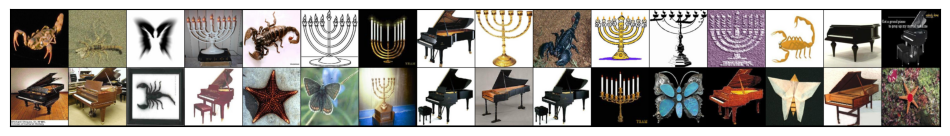

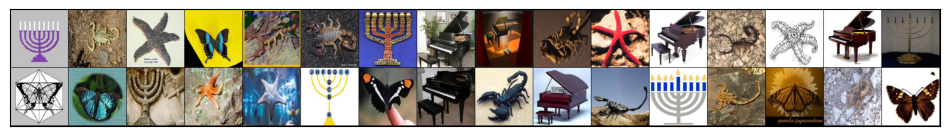

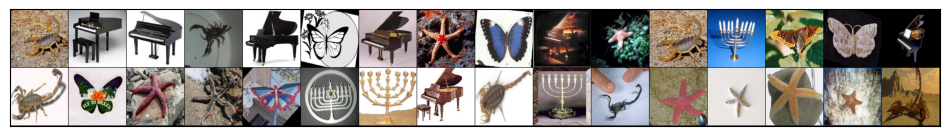

In [66]:
from torchvision.utils import make_grid

def show_batch(dl):
    tot = 0
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        tot+=1

        if tot == 3:
          break


show_batch(train_dataloader)

In [87]:
# Model Definition
class arch1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.ModuleList([
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=11, stride=4, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),


        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Flatten(),

        nn.Linear(in_features=16*10*10, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=5),
        nn.Softmax(dim=1)
    ])

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
      # print(x.shape)
    return x

# Model Definition
class arch2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.ModuleList([
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=11, stride=4, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),


        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Flatten(),
        # (10 - 3)/1 +1 = 8
        # (8 - 3)/2 +1 = 3

        nn.Linear(in_features=32*3*3, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=5),
        nn.Softmax(dim=1)
    ])

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

# Model Definition
class arch3(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.ModuleList([
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=11, stride=4, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),


        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
        nn.MaxPool2d(kernel_size=3, stride=2),


        nn.Flatten(),

        nn.Linear(in_features=64*2*2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=5),
        nn.Softmax(dim=1)
    ])

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

# Architecture 1 (4 Layers)

In [47]:
# First convolutional layer contains 8 11x11
# filters with stride 4 and padding 0 followed by 3x3 max pooling operation with stride 2.

# The second convolutional layer contains 16 5x5 filters with stride 1 and padding 0
# followed by 3x3 max pooling operation with stride 2.
# Then flatten it and add two fully connected layers.

# Consider 128 hidden nodes with rectified linear activation function in
# the first hidden layer and 5 neurons with a softmax activation function in the second layer (output layer).

In [48]:
# Training
def train_model(name, model, loss_fn, train_dataloader, optimizer, epochs=10):
  for epoch in range(epochs):
    running_loss = 0.0

    for images, labels in train_dataloader:
      images, labels = images.to(device), labels.to(device)

      # forward pass
      y_pred = model.forward(images)
      loss = loss_fn(y_pred, labels)
      optimizer.zero_grad()

      # backward pass
      loss.backward()

      # update weights
      optimizer.step()

      running_loss += loss.item() * images.size(0)

    avg_epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_epoch_loss:.4f}')

  torch.save(model.state_dict(), name+".pth")

import torch

# Evaluate accuracy function
def evaluate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in data_loader:
            # Move inputs and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, predicted = torch.max(outputs, 1)

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store labels and predictions for further analysis (e.g., confusion matrix)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    return accuracy, all_labels, all_preds


In [49]:
model = arch1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

train_model("arch1", model, loss_fn, train_dataloader, optimizer, 100)

Epoch [1/100], Average Loss: 1.6084
Epoch [2/100], Average Loss: 1.5842
Epoch [3/100], Average Loss: 1.5210
Epoch [4/100], Average Loss: 1.4620
Epoch [5/100], Average Loss: 1.4398
Epoch [6/100], Average Loss: 1.3984
Epoch [7/100], Average Loss: 1.3875
Epoch [8/100], Average Loss: 1.3929
Epoch [9/100], Average Loss: 1.3620
Epoch [10/100], Average Loss: 1.3490
Epoch [11/100], Average Loss: 1.3633
Epoch [12/100], Average Loss: 1.3233
Epoch [13/100], Average Loss: 1.3209
Epoch [14/100], Average Loss: 1.3064
Epoch [15/100], Average Loss: 1.2791
Epoch [16/100], Average Loss: 1.2677
Epoch [17/100], Average Loss: 1.2534
Epoch [18/100], Average Loss: 1.2598
Epoch [19/100], Average Loss: 1.2111
Epoch [20/100], Average Loss: 1.2022
Epoch [21/100], Average Loss: 1.1903
Epoch [22/100], Average Loss: 1.1874
Epoch [23/100], Average Loss: 1.1726
Epoch [24/100], Average Loss: 1.1664
Epoch [25/100], Average Loss: 1.1689
Epoch [26/100], Average Loss: 1.1493
Epoch [27/100], Average Loss: 1.1305
Epoch [28/

torch.Size([3, 224, 224])
tensor([[3.1508e-07, 8.2348e-14, 9.9940e-01, 1.0819e-04, 4.9548e-04]],
       grad_fn=<SoftmaxBackward0>)


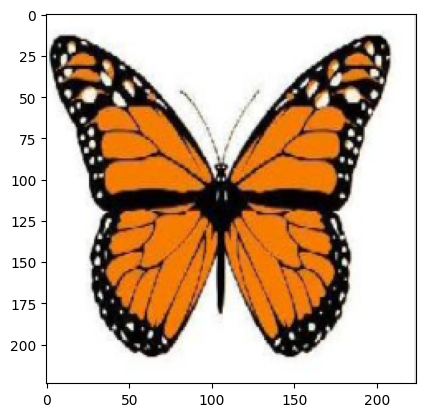

In [85]:
# img = train_dataloader.dataset[0]
# img = img[0].to(device)
# plt.imshow(img.permute(1, 2, 0))

# # x = model.forward(img)


# for images, labels in train_dataloader:
#   images, labels = images.to(device), labels.to(device)
#   print(images[0].shape)
#   x = model.forward(images[0].unsqueeze(0))
#   print(x)
#   break

In [50]:
train_accuracy, train_labels, train_preds = evaluate_accuracy(model, train_dataloader)
val_accuracy, val_labels, val_preds = evaluate_accuracy(model, val_dataloader)

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


Training Accuracy: 95.20%
Validation Accuracy: 80.00%


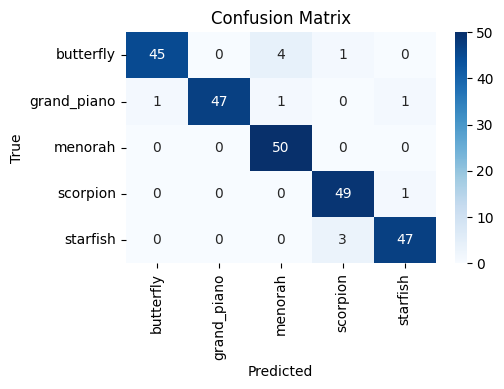

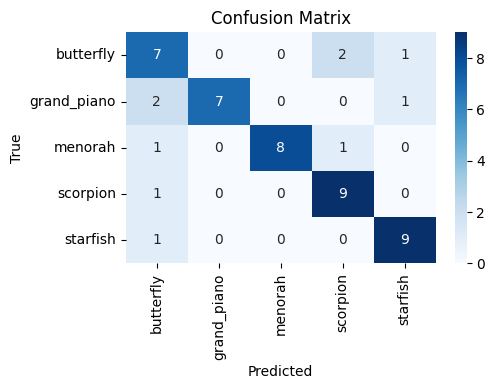

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming classes are the same for both train and val datasets
classes = train_dataset.classes
plot_confusion_matrix(train_labels, train_preds, classes)
plot_confusion_matrix(val_labels, val_preds, classes)

# Architecture 2

In [52]:
model = arch2().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

train_model("arch2", model, loss_fn, train_dataloader, optimizer, 100)

Epoch [1/100], Average Loss: 1.6094
Epoch [2/100], Average Loss: 1.6048
Epoch [3/100], Average Loss: 1.5932
Epoch [4/100], Average Loss: 1.5686
Epoch [5/100], Average Loss: 1.5282
Epoch [6/100], Average Loss: 1.4825
Epoch [7/100], Average Loss: 1.4478
Epoch [8/100], Average Loss: 1.4433
Epoch [9/100], Average Loss: 1.4095
Epoch [10/100], Average Loss: 1.4043
Epoch [11/100], Average Loss: 1.3955
Epoch [12/100], Average Loss: 1.3874
Epoch [13/100], Average Loss: 1.3978
Epoch [14/100], Average Loss: 1.4015
Epoch [15/100], Average Loss: 1.3684
Epoch [16/100], Average Loss: 1.3618
Epoch [17/100], Average Loss: 1.3689
Epoch [18/100], Average Loss: 1.3420
Epoch [19/100], Average Loss: 1.3339
Epoch [20/100], Average Loss: 1.3252
Epoch [21/100], Average Loss: 1.3170
Epoch [22/100], Average Loss: 1.3196
Epoch [23/100], Average Loss: 1.3238
Epoch [24/100], Average Loss: 1.3327
Epoch [25/100], Average Loss: 1.3194
Epoch [26/100], Average Loss: 1.2990
Epoch [27/100], Average Loss: 1.3036
Epoch [28/

Training Accuracy: 73.20%
Validation Accuracy: 56.00%


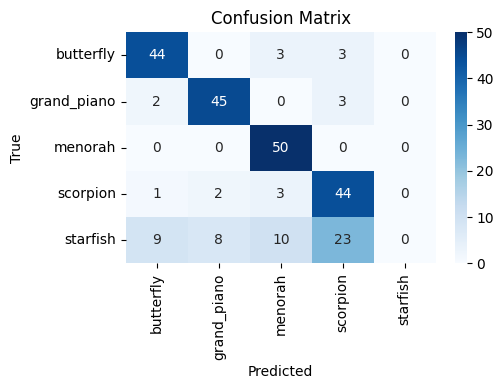

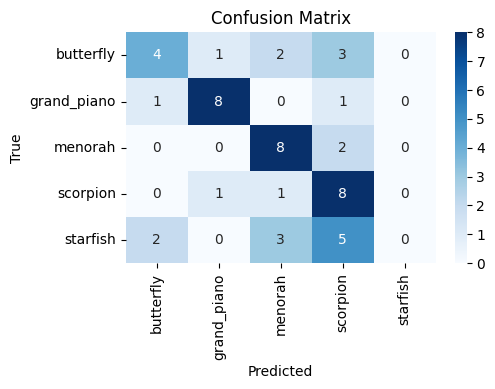

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

train_accuracy, train_labels, train_preds = evaluate_accuracy(model, train_dataloader)
val_accuracy, val_labels, val_preds = evaluate_accuracy(model, val_dataloader)

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


# Compute confusion matrix
def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming classes are the same for both train and val datasets
classes = train_dataset.classes
plot_confusion_matrix(train_labels, train_preds, classes)
plot_confusion_matrix(val_labels, val_preds, classes)

# Architecture 3

In [54]:
model = arch3().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

train_model("arch3", model, loss_fn, train_dataloader, optimizer, 100)

Epoch [1/100], Average Loss: 1.6092
Epoch [2/100], Average Loss: 1.6049
Epoch [3/100], Average Loss: 1.5937
Epoch [4/100], Average Loss: 1.5766
Epoch [5/100], Average Loss: 1.5360
Epoch [6/100], Average Loss: 1.4981
Epoch [7/100], Average Loss: 1.4671
Epoch [8/100], Average Loss: 1.4485
Epoch [9/100], Average Loss: 1.4349
Epoch [10/100], Average Loss: 1.4001
Epoch [11/100], Average Loss: 1.3912
Epoch [12/100], Average Loss: 1.4045
Epoch [13/100], Average Loss: 1.3824
Epoch [14/100], Average Loss: 1.3671
Epoch [15/100], Average Loss: 1.3550
Epoch [16/100], Average Loss: 1.3495
Epoch [17/100], Average Loss: 1.3469
Epoch [18/100], Average Loss: 1.3498
Epoch [19/100], Average Loss: 1.3118
Epoch [20/100], Average Loss: 1.3001
Epoch [21/100], Average Loss: 1.2831
Epoch [22/100], Average Loss: 1.2820
Epoch [23/100], Average Loss: 1.2850
Epoch [24/100], Average Loss: 1.2690
Epoch [25/100], Average Loss: 1.2634
Epoch [26/100], Average Loss: 1.2461
Epoch [27/100], Average Loss: 1.2287
Epoch [28/

Training Accuracy: 93.20%
Validation Accuracy: 66.00%


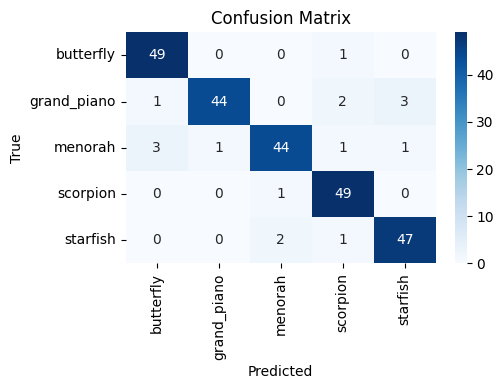

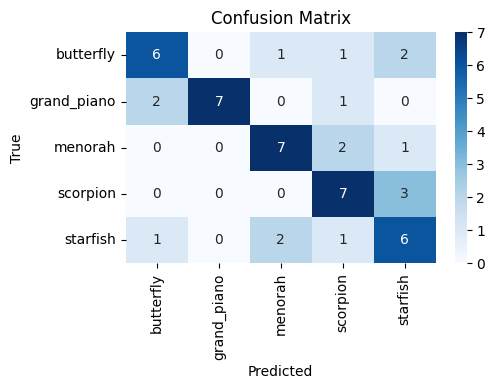

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

train_accuracy, train_labels, train_preds = evaluate_accuracy(model, train_dataloader)
val_accuracy, val_labels, val_preds = evaluate_accuracy(model, val_dataloader)

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


# Compute confusion matrix
def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming classes are the same for both train and val datasets
classes = train_dataset.classes
plot_confusion_matrix(train_labels, train_preds, classes)
plot_confusion_matrix(val_labels, val_preds, classes)

In [56]:
# So best architecture on training and
# validation dataset is Architecture 1

<ipython-input-57-52c9bb6db4f9>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('arch1.pth'))


Test Accuracy: 73.00%


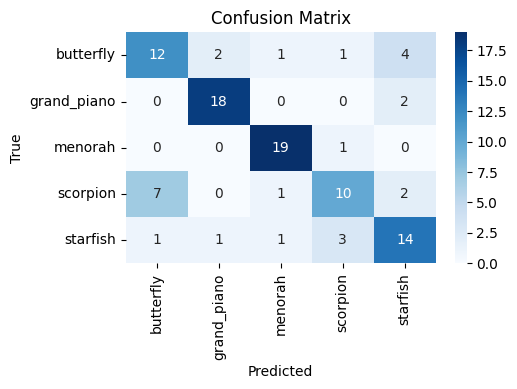

In [57]:
# Testing architecture 1
from sklearn.metrics import confusion_matrix
import seaborn as sns

model = arch1().to(device)

# Load the saved model weights
model.load_state_dict(torch.load('arch1.pth'))

# Set the model to evaluation mode
model.eval()


test_accuracy, test_labels, test_preds = evaluate_accuracy(model, test_dataloader)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# Compute confusion matrix
def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming classes are the same for both train and val datasets
classes = test_dataset.classes
plot_confusion_matrix(test_labels, test_preds, classes)

In [58]:

# SUMMARY OF ARCH1
from torchsummary import summary

model = arch1().to(device)
model.load_state_dict(torch.load('arch1.pth'))

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 54, 54]           2,912
         MaxPool2d-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 22, 22]           3,216
         MaxPool2d-4           [-1, 16, 10, 10]               0
           Flatten-5                 [-1, 1600]               0
            Linear-6                  [-1, 128]         204,928
              ReLU-7                  [-1, 128]               0
            Linear-8                    [-1, 5]             645
           Softmax-9                    [-1, 5]               0
Total params: 211,701
Trainable params: 211,701
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.30
Params size (MB): 0.81
Estimated Total Size (MB): 1.69
-------------------------------------------

<ipython-input-58-43e5236850e8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('arch1.pth'))


Conv2d(3, 8, kernel_size=(11, 11), stride=(4, 4))
(8, 3, 11, 11)


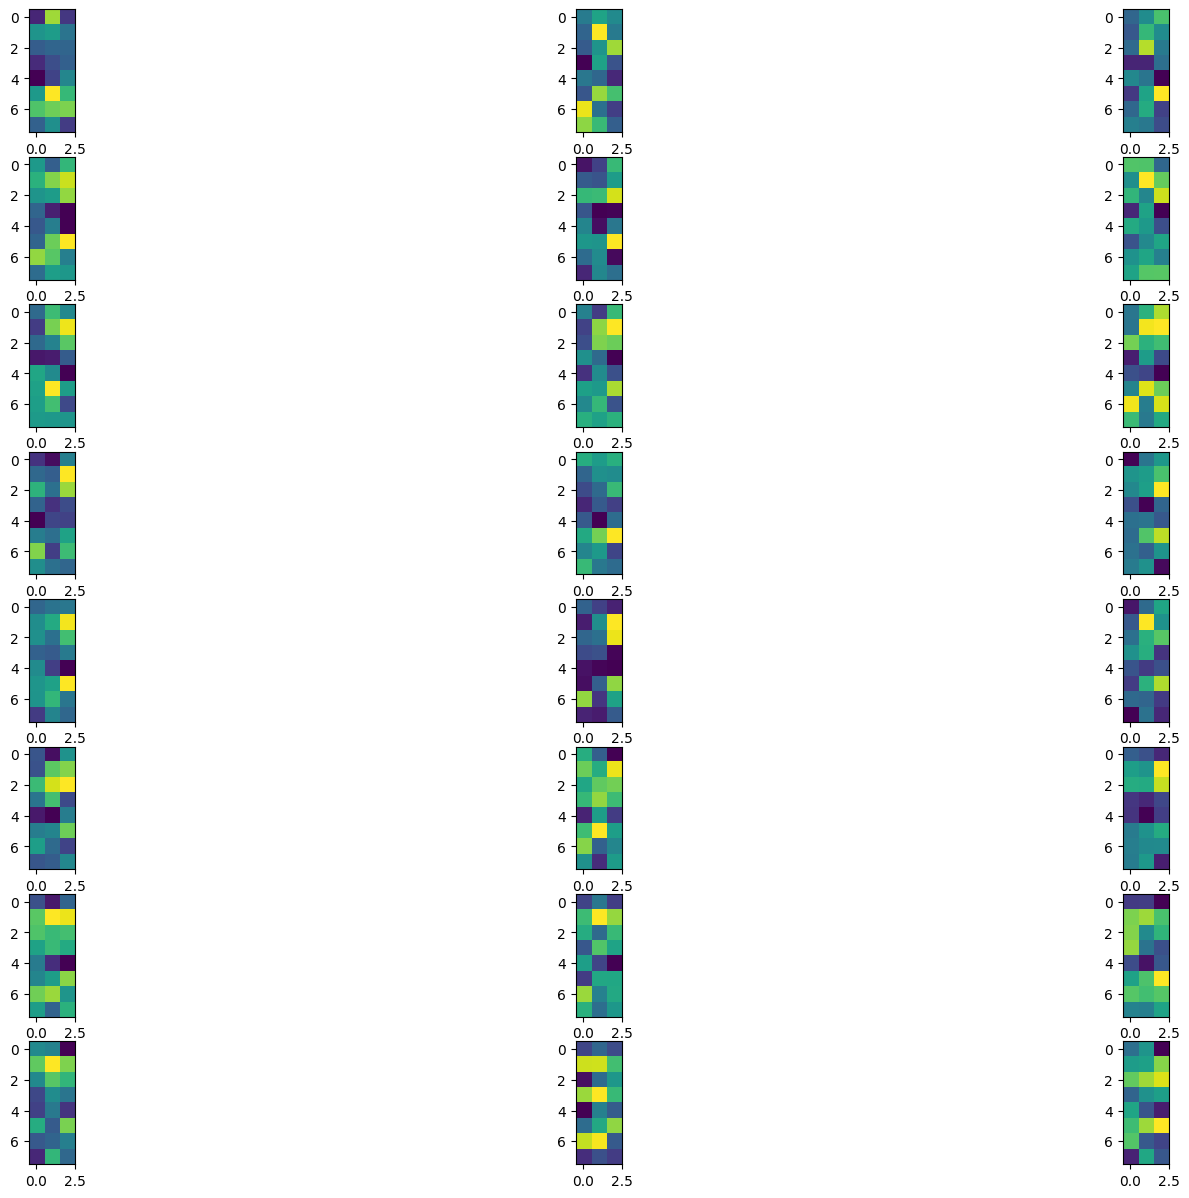

In [59]:
# VISUALIZING KERNEL

import matplotlib.pyplot as plt

print(model.layers[0])
filters , bias = model.layers[0].weight.data.cpu().numpy(),model.layers[0].bias.data.cpu().numpy()
print(filters.shape)


n_filters = 8
ix=1

fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j])
        ix+=1

#plot the filters
plt.show()

In [123]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, layer_index):
        super().__init__()

        self.model = model
        self.layer_index = layer_index
        self.feature_map = None

        # print(list(model.layers.children())[0])
        # Get the layer you want to extract the output from
        layer = list(model.layers.children())[layer_index]

        # Register a hook to capture the layer output
        layer.register_forward_hook(self.get_feature_map)

    def get_feature_map(self, module, input, output):
        self.feature_map = output

    def forward(self, x):
        _ = self.model(x)  # Forward pass to get the feature map
        print(classes[_.argmax()])

        return self.feature_map[0]

def show_feature_maps(feature_map):
  # Create a figure with subplots
  num_maps = feature_map.shape[0]
  fig, axes = plt.subplots((num_maps + 3) // 4, 4, figsize=(10, 5))

  # Plot each feature map
  for i in range(num_maps):
      axes[i // 4, i % 4].imshow(feature_map[i].detach().cpu(), cmap='gray')  # Detach and move to CPU
      axes[i // 4, i % 4].axis('off')

  # Hide any unused subplots
  for j in range(num_maps, axes.size):
      axes[j // 4, j % 4].axis('off')

  plt.tight_layout()
  plt.show()

torch.Size([3, 224, 224])


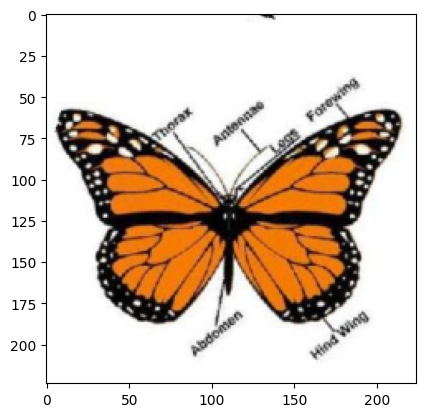

In [124]:
import matplotlib.pyplot as plt

input_img = train_dataloader.dataset[10]
input_img = input_img[0].to(device)

print(input_img.shape)
plt.imshow(input_img.permute(1, 2, 0))

butterfly
torch.Size([8, 54, 54])


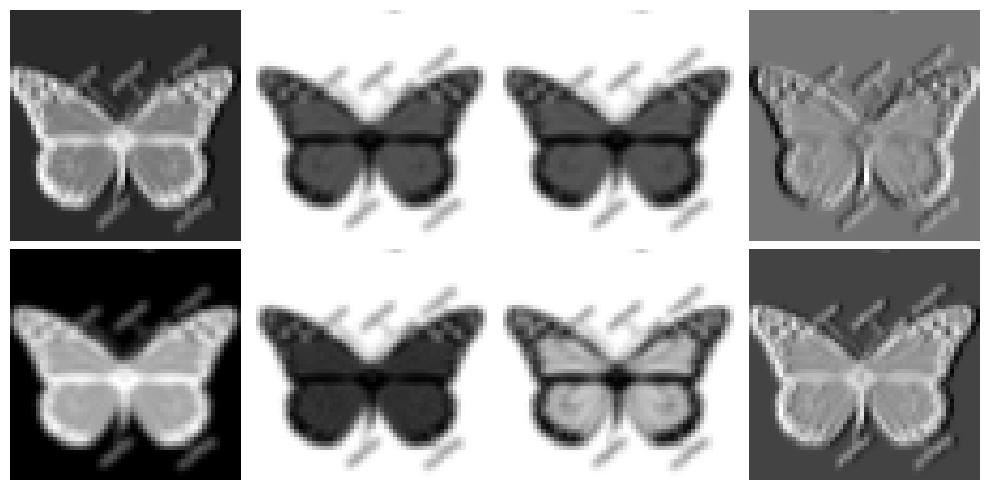

In [125]:
# VISUALIZING FIRST LAYER FEATURE MAP
import torch
import matplotlib.pyplot as plt

feature_extractor = FeatureExtractor(model1, layer_index=0)

input_img = train_dataloader.dataset[10]
input_img = input_img[0].to(device)

feature_map = feature_extractor(input_img.unsqueeze(0))
print(feature_map.shape)

show_feature_maps(feature_map)


butterfly
torch.Size([16, 22, 22])


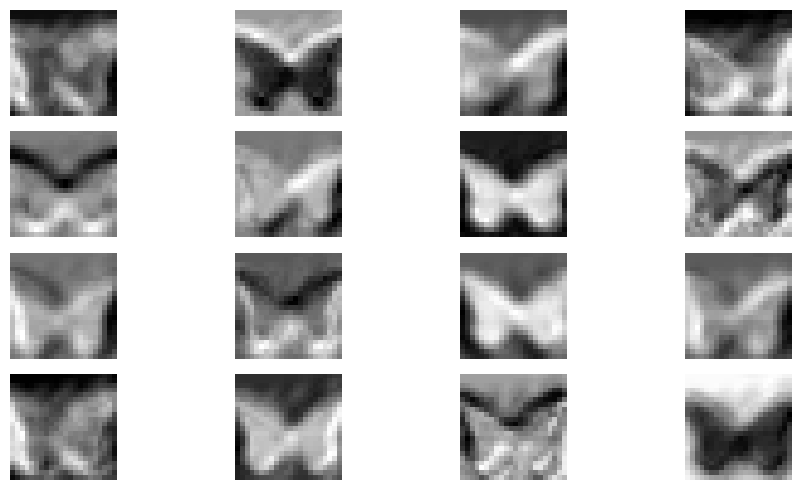

In [126]:
# VISUALIZING SECOND CONV LAYER FEATURE MAP
import torch
import matplotlib.pyplot as plt

feature_extractor = FeatureExtractor(model1, layer_index=2)
feature_map = feature_extractor(input_img.unsqueeze(0))

print(feature_map.shape)
show_feature_maps(feature_map)
